In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift, ifft2, ifftshift

Implementar la función create_gauss_filter (h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.

In [8]:
def create_gauss_filter(h, w, k_size, sigma):
    """Creates a 2D Gaussian filter and its Fourier transform.

    Args:
        h (int): Height of the filter.
        w (int): Width of the filter.
        k_size (int): Size of the kernel.
        sigma (float): Standard deviation for the Gaussian kernel.

    Returns:
        filter_spatial (numpy.ndarray): The 2D Gaussian filter.
        filter_fourier (numpy.ndarray): Fourier transform of the Gaussian filter.
    """
    # Create a 1D Gaussian kernel
    kernel = cv2.getGaussianKernel(k_size, sigma)

    # Compute the 2D Gaussian filter by multiplying the 1D kernel with its transpose
    filter_spatial = np.outer(kernel, kernel.T)

    # Pad the filter to the desired size (h x w) with zeros
    filter_spatial_padded = np.zeros((h, w))
    filter_spatial_padded[:k_size, :k_size] = filter_spatial

    # Compute the Fourier transform of the Gaussian filter
    filter_fourier = fftshift(fft2(filter_spatial_padded))

    return filter_spatial_padded, filter_fourier

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.

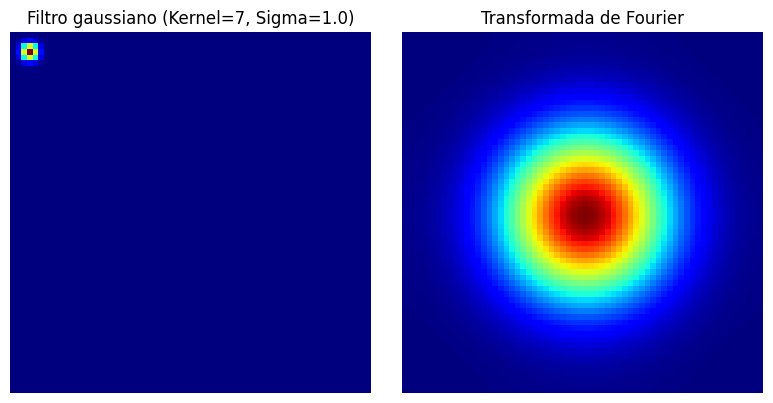

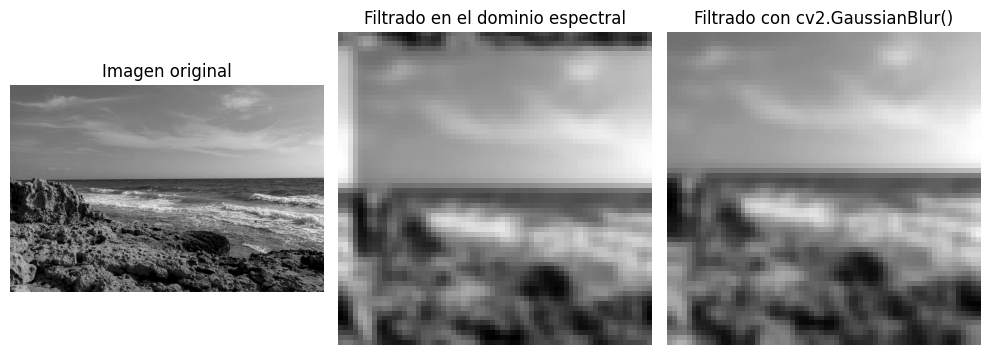

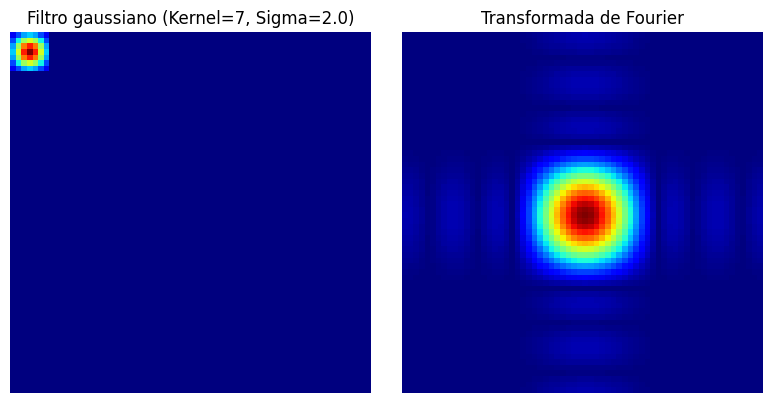

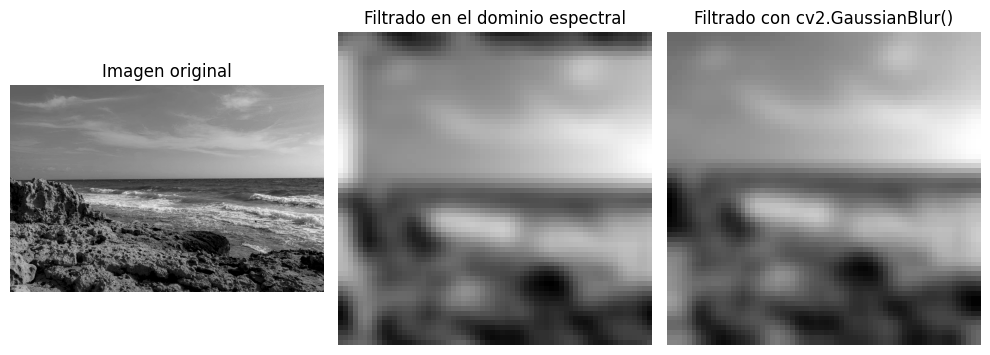

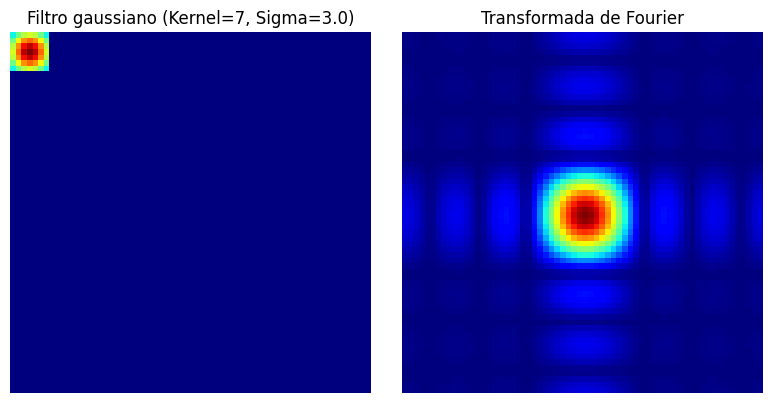

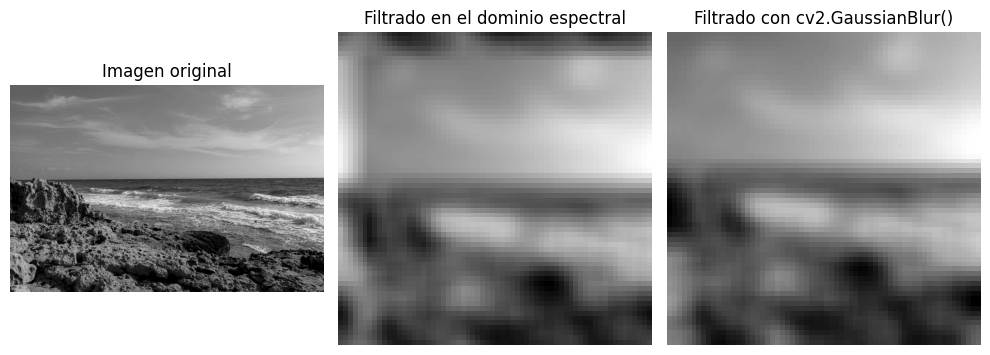

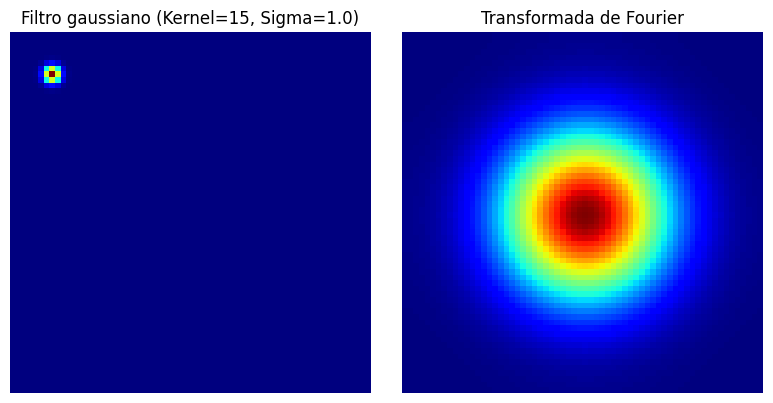

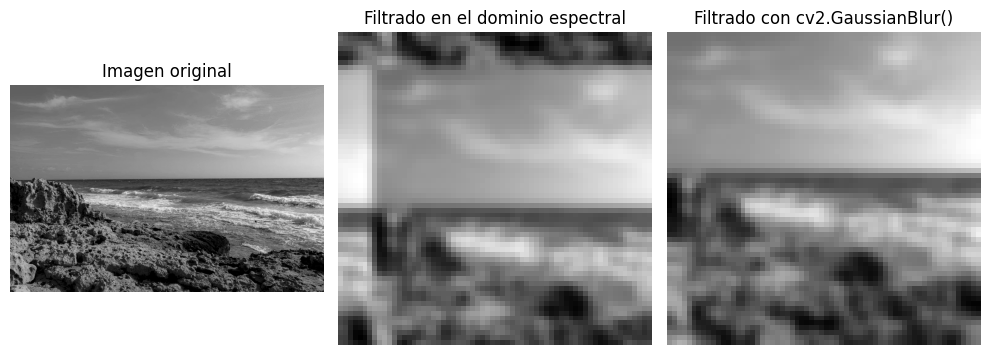

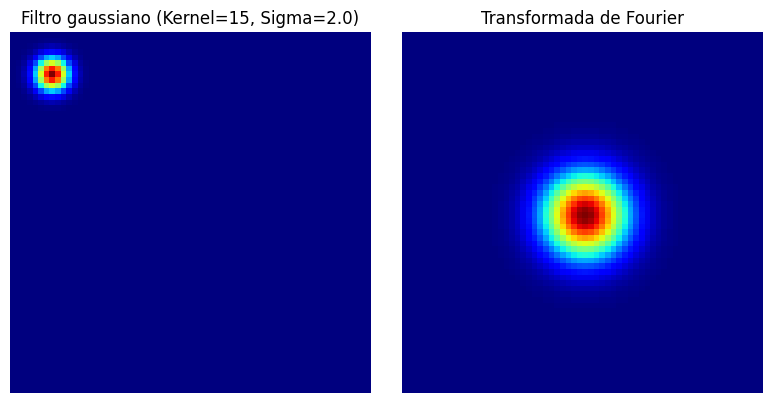

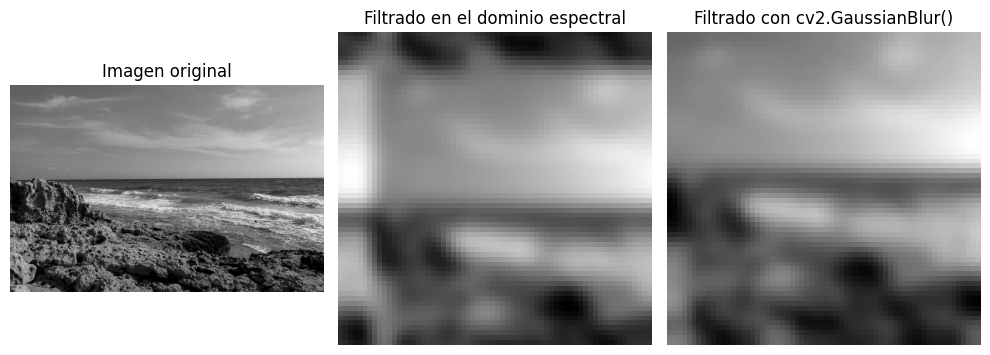

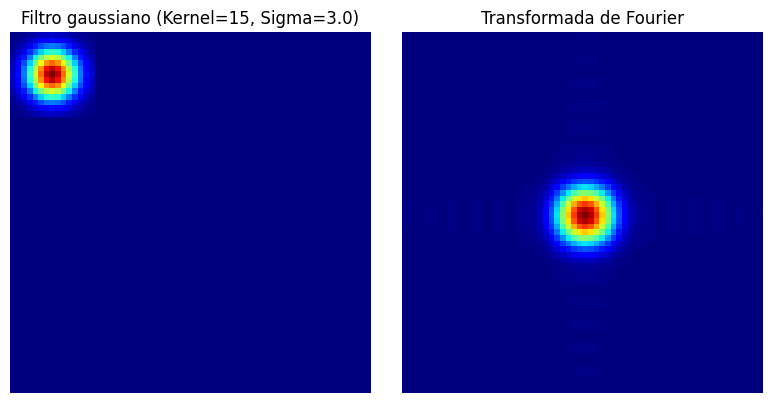

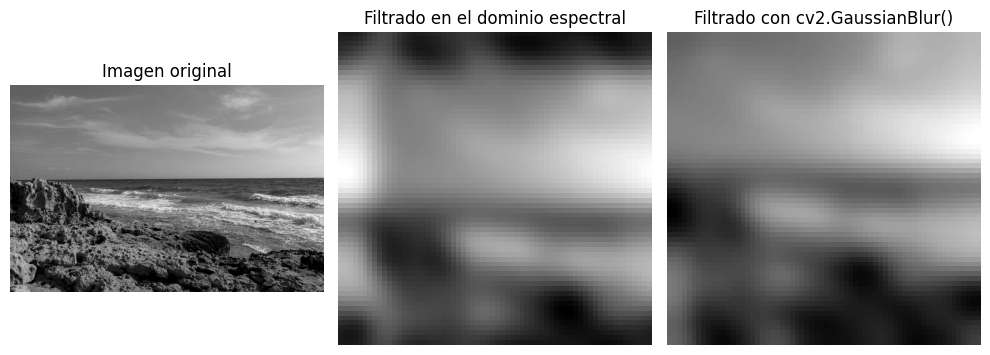

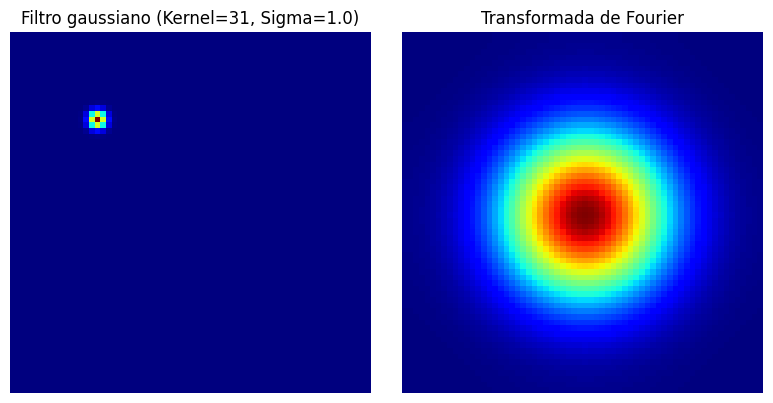

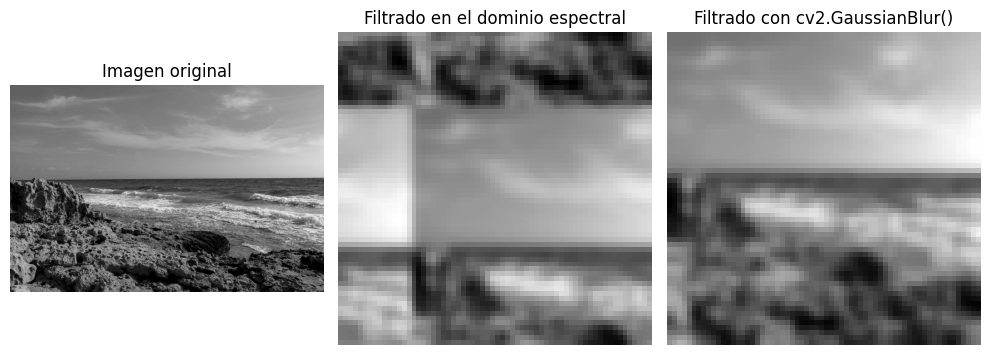

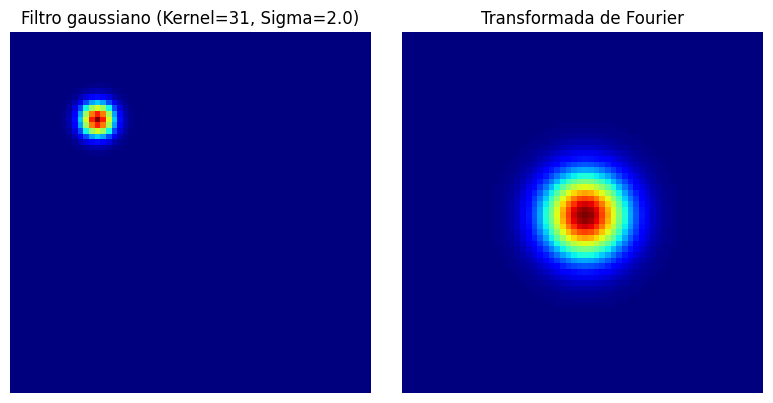

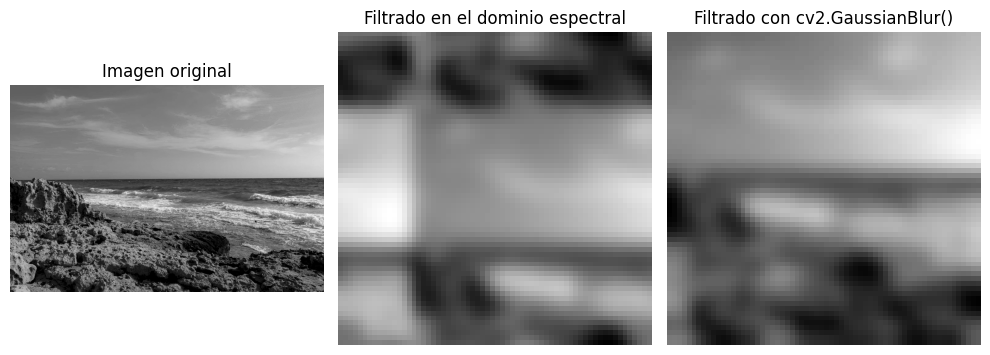

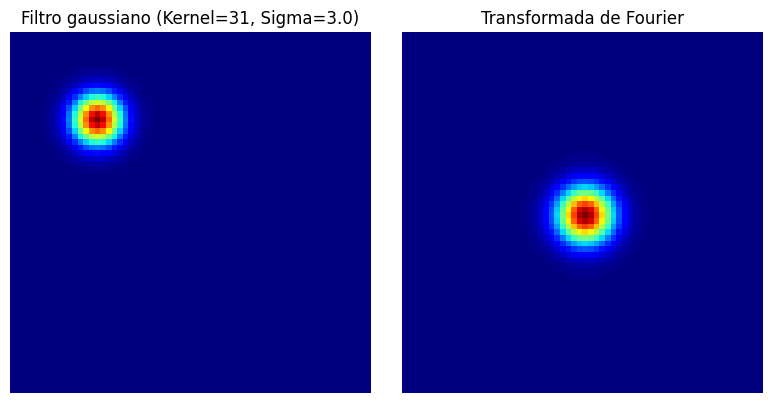

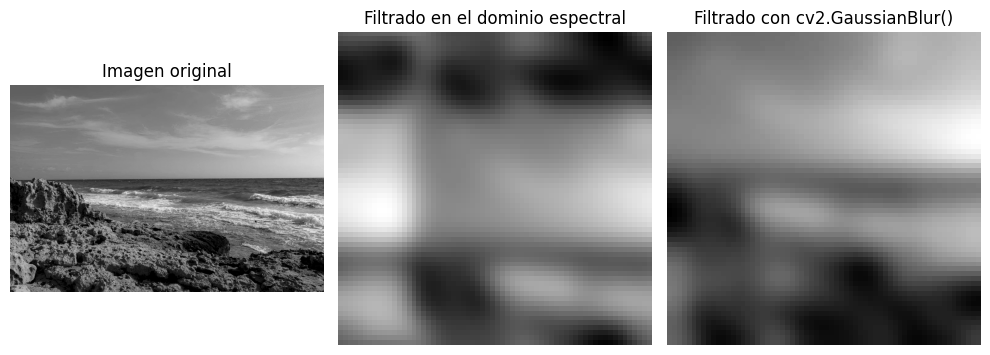

In [10]:
# Parámetros del filtro
h, w = 64, 64
k_sizes = [7, 15, 31]
sigmas = [1.0, 2.0, 3.0]

# Cargar una imagen de ejemplo
image = cv2.imread(r'Material_TPs/TP2/img1.png', cv2.IMREAD_GRAYSCALE)

# Graficar las representaciones del filtro para diferentes tamaños de kernel y sigma
for k_size in k_sizes:
    for sigma in sigmas:
        # Crear el filtro gaussiano y su transformada de Fourier
        filter_spatial, filter_fourier = create_gauss_filter(h, w, k_size, sigma)

        # Redimensionar la imagen para que coincida con el tamaño del filtro
        image_resized = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)

        # Aplicar la transformada de Fourier a la imagen redimensionada
        image_fourier = fftshift(fft2(image_resized))

        # Aplicar el filtro gaussiano en el dominio espectral
        filtered_image_fourier = image_fourier * filter_fourier

        # Obtener la imagen filtrada en el dominio espacial
        filtered_image = np.real(ifft2(ifftshift(filtered_image_fourier)))

        # Filtrar la imagen utilizando cv2.GaussianBlur()
        filtered_image_cv2 = cv2.GaussianBlur(image_resized, (k_size, k_size), sigmaX=sigma, sigmaY=sigma)

        # Graficar el filtro en el dominio espacial
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(filter_spatial, cmap='jet')
        plt.title(f'Filtro gaussiano (Kernel={k_size}, Sigma={sigma})')
        plt.axis('off')

        # Graficar la transformada de Fourier del filtro
        plt.subplot(1, 2, 2)
        plt.imshow(np.abs(filter_fourier), cmap='jet')
        plt.title('Transformada de Fourier')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Graficar la imagen original y la imagen filtrada
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Imagen original')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(filtered_image, cmap='gray')
        plt.title('Filtrado en el dominio espectral')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(filtered_image_cv2, cmap='gray')
        plt.title('Filtrado con cv2.GaussianBlur()')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

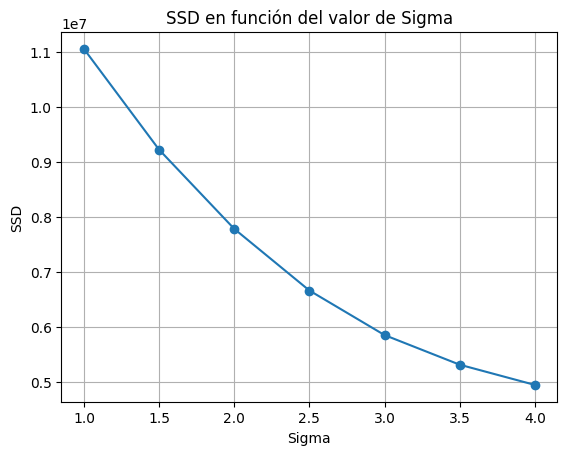

In [12]:
# Parámetros del filtro
h, w = 64, 64
k_size = 15
sigmas = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

# Cargar una imagen de ejemplo
image = cv2.imread(r'Material_TPs/TP2/img1.png', cv2.IMREAD_GRAYSCALE)

ssd_values = []
# Filtrar la imagen utilizando cv2.GaussianBlur() con diferentes sigmas y calcular el SSD
for sigma in sigmas:
    _, filter_fourier = create_gauss_filter(h, w, k_size, sigma)
    image_resized = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
    image_fourier = fftshift(fft2(image_resized))
    filtered_image_fourier = image_fourier * filter_fourier
    filtered_image = np.real(ifft2(ifftshift(filtered_image_fourier)))
    filtered_image_cv2 = cv2.GaussianBlur(image_resized, (k_size, k_size), sigmaX=sigma, sigmaY=sigma)
    ssd = np.sum((filtered_image - filtered_image_cv2) ** 2)
    ssd_values.append(ssd)

# Graficar el resultado del SSD en función del sigma utilizado
plt.plot(sigmas, ssd_values, marker='o')
plt.xlabel('Sigma')
plt.ylabel('SSD')
plt.title('SSD en función del valor de Sigma')
plt.grid(True)
plt.show()

2. Usando el método descripto en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain" comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [19]:
def image_quality_measure(image):
    # Calcular la transformada de Fourier de la imagen
    f = np.fft.fftshift(np.fft.fft2(image))

    # Calcular el espectro de frecuencia centrado
    fc = np.abs(f)

    # Calcular el valor máximo en el espectro de frecuencia centrado
    m = np.max(fc)

    # Calcular el umbral para contar los píxeles significativos en el espectro de frecuencia
    thres = m / 1000

    # Contar los píxeles significativos en el espectro de frecuencia
    th = np.sum(fc > thres)

    # Calcular la medida de calidad de imagen (FM)
    fm = th / (m * image.size)

    return fm

# Cargar la imagen
image = cv2.imread(r'Material_TPs/TP2/img1.png', cv2.IMREAD_GRAYSCALE)

# Realizar el filtrado por convolución
kernel = np.ones((5, 5)) / 25
image_convolved = cv2.filter2D(image, -1, kernel)

# Aplicar el filtrado en el dominio espectral
image_fourier = np.fft.fftshift(np.fft.fft2(image))
kernel_fourier = np.fft.fftshift(np.fft.fft2(kernel, s=image.shape))
image_filtered_fourier = image_fourier * kernel_fourier
image_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(image_filtered_fourier)))

# Calcular la medida de calidad de imagen (FM) para cada método de filtrado
fm_convolved = image_quality_measure(image_convolved)
fm_filtered = image_quality_measure(image_filtered)

print('Medida de calidad de imagen (FM) - Filtrado por convolución:', fm_convolved)
print('Medida de calidad de imagen (FM) - Filtrado espectral:', fm_filtered)


Medida de calidad de imagen (FM) - Filtrado por convolución: 1.424141036693793e-10
Medida de calidad de imagen (FM) - Filtrado espectral: 1.3902121121169577e-10


3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper "Analysis of focus measure operators in shape-from-focus"

In [20]:
# Esta metrica es definida en el apendice del paper (pagina 1429)
def laplacian_variance(image):
    # Calcular el Laplaciano de la imagen
    laplacian = cv2.Laplacian(image, cv2.CV_64F)

    # Calcular la media del Laplaciano
    mean = np.mean(laplacian)

    # Calcular la varianza del Laplaciano
    variance = np.mean((laplacian - mean) ** 2)

    return variance

# Cargar la imagen
image = cv2.imread(r'Material_TPs/TP2/img1.png', cv2.IMREAD_GRAYSCALE)

# Realizar el filtrado por convolución
kernel = np.ones((5, 5)) / 25
image_convolved = cv2.filter2D(image, -1, kernel)

# Aplicar el filtrado en el dominio espectral
image_fourier = np.fft.fftshift(np.fft.fft2(image))
kernel_fourier = np.fft.fftshift(np.fft.fft2(kernel, s=image.shape))
image_filtered_fourier = image_fourier * kernel_fourier
image_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(image_filtered_fourier)))

# Calcular la metrica
fm_convolved = laplacian_variance(image_convolved)
fm_filtered = laplacian_variance(image_filtered)

print('Medida de calidad de imagen (Laplacian var) - Filtrado por convolución:', fm_convolved)
print('Medida de calidad de imagen (Laplacian var) - Filtrado espectral:', fm_filtered)


Medida de calidad de imagen (Laplacian var) - Filtrado por convolución: 41.57212028693083
Medida de calidad de imagen (Laplacian var) - Filtrado espectral: 43.85526710495294
